 # Wake County Fire Call Volume Trends
 
 
 Using data from the Wake County Open Data Portal:
 
 - [Fire Incidents](https://data-wake.opendata.arcgis.com/datasets/ral::fire-incidents)
  - All EMS-related calls (codes 300-399 and 661) are missing
  - The entire month of October 2018 is missing

In [1]:
# Standard notebook setup
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook

Load the Fire Incidents file as a [Pandas](http://pandas.pydata.org/pandas-docs/stable/10min.html) data frame, indexed by dispatch time.

In [2]:
df = fire_incidents = pd.read_csv('data/Fire_Incidents.csv',
                                  index_col='dispatch_date_time')
print("Loaded", len(df), "incidents")  # 177738

Loaded 177738 incidents


## Data cleanup and filtering

The raw data needs some work before we can use it.

In [3]:
# Convert index to correct data type
df.index = pd.to_datetime(df.index)

# Sort rows by time, using a stable sort
df.sort_index(inplace=True, kind='mergesort')

# Filter out rows with missing/invalid dispatch times
print(len(df[df.index.notnull()]))  # 176284
df.drop(df.index[sum(df.index.notnull()):], inplace=True)

# Count incidents by month and year
monthly = df.groupby(pd.Grouper(freq='M')).count()
yearly = df.groupby(pd.Grouper(freq='Y')).count()

176284


## Call Volume by Month

This graph shows the number of reported fire incidents per month for every month since the data began, except for the last month which usually has incomplete data.

<IPython.core.display.Javascript object>


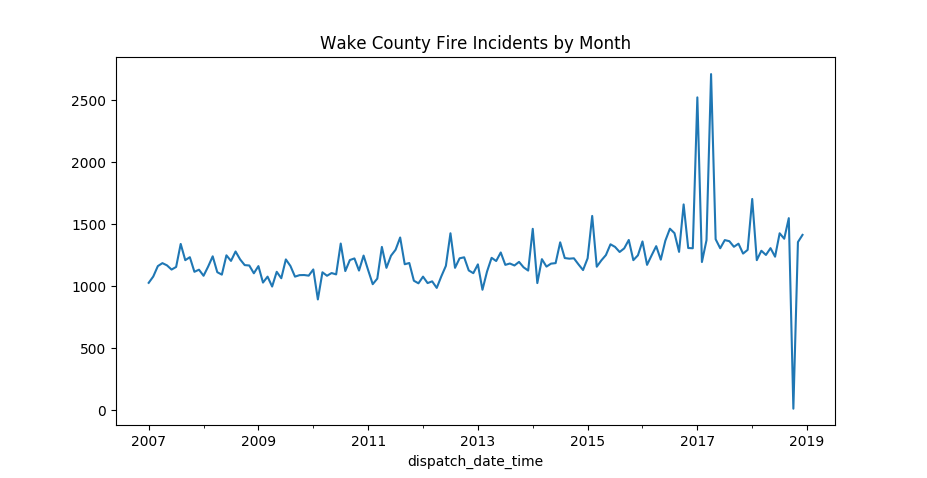

In [4]:
%matplotlib notebook
text = "Wake County Fire Incidents by Month"
p = monthly['incident_number'][:-1].plot(title=text)
# p = plt.plot(monthly.index, monthly['incident_number'])